In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


data_path = 'C:/Users/Usuario/Desktop/data-science/dialogic_accounting_pibic/data'

# Carrega o dataframe
df = pd.read_excel(data_path + '/results/2_independent_variable_4024.xlsx')
df = df.dropna(subset=['IEngajamento'])
df["log_IEngajamento"] = np.log1p(df["IEngajamento"])

In [17]:
variaveis_base = [
    'classify_5_inverted',
    'content_type',
    'posts_per_day',
    'period_of_day',
    'num_hashtags',
    'flesch_index',
    'call_to_action',
    'gov_commented',
]

In [4]:
variaveis_independentes = [
    'num_hashtags',
    'content_type',
    'posts_per_day'
]

In [4]:
def rodar_regressao(df, variaveis, label, regiao=False):
    X = df[variaveis].copy()
    if regiao is not False:
        X = df[df['regiao'] == regiao][variaveis].copy()

    X = pd.get_dummies(X, drop_first=True)
    X = sm.add_constant(X).astype(float)
    Y = df["log_IEngajamento"]

    modelo = sm.OLS(Y, X).fit(cov_type="HAC", cov_kwds={"maxlags": 5})
    print(f"\n=== Modelo {label} ===")
    print(modelo.summary())

    print("\n=== VIF (Multicolinearidade) ===")
    vif = pd.DataFrame()
    vif["Variável"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print(vif)
    return modelo

In [28]:
resultados = rodar_regressao(df, variaveis_independentes, label="Geral")


=== Modelo Geral ===
                            OLS Regression Results                            
Dep. Variable:       log_IEngajamento   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     28.99
Date:                Sun, 31 Aug 2025   Prob (F-statistic):           8.26e-69
Time:                        09:37:49   Log-Likelihood:                -4994.7
No. Observations:                3710   AIC:                         1.002e+04
Df Residuals:                    3696   BIC:                         1.010e+04
Df Model:                          13                                         
Covariance Type:                  HAC                                         
                                                                coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------

In [18]:
df[variaveis_base].columns

Index(['classify_5_inverted', 'content_type', 'posts_per_day', 'period_of_day',
       'num_hashtags', 'flesch_index', 'call_to_action', 'gov_commented'],
      dtype='object')

In [12]:
df[variaveis_base].describe(include='object')

,classify_5_inverted,content_type,period_of_day
count,3710,3710,3710
unique,5,2,4
top,Nível 2 (Baixo Detalhe Intermediário),Imagem,Noite
freq,1803,2049,1676


In [19]:
df['classify_5_inverted'].value_counts(normalize=True)

classify_5_inverted
Nível 2 (Baixo Detalhe Intermediário)    0.485984
Nível 1 (Mínimo ou Genérico)             0.291105
Nível 3 (Detalhe Moderado/Médio)         0.142588
Nível 4 (Alto Detalhe)                   0.074394
Nível 5 (Extremo Detalhe)                0.005930
Name: proportion, dtype: float64

In [10]:
df['IEngajamento'].dropna().describe()

count    3710.000000
mean      214.637332
std       292.599190
min         2.500000
25%        68.000000
50%       134.000000
75%       253.875000
max      7049.000000
Name: IEngajamento, dtype: float64

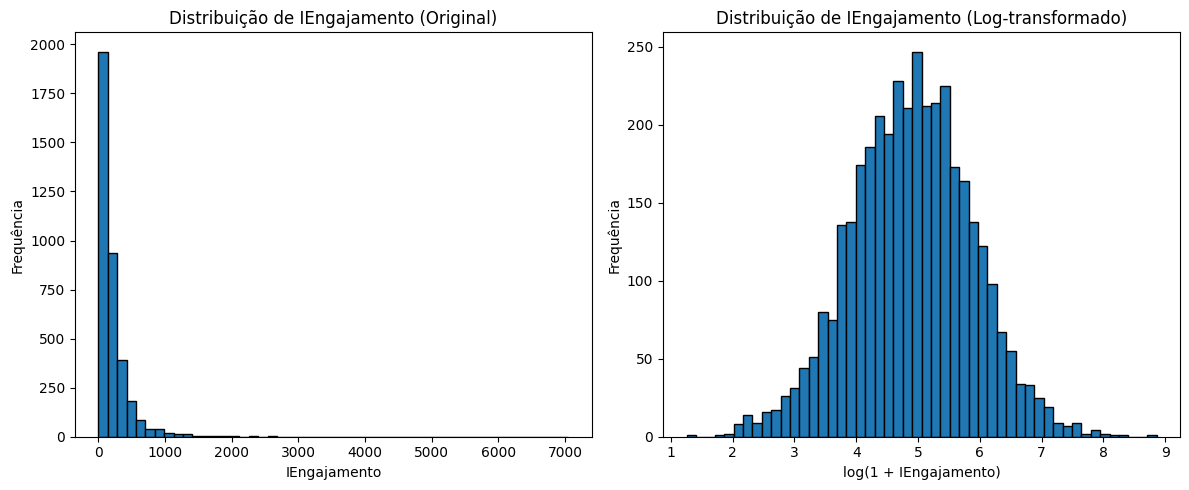

In [11]:
import matplotlib.pyplot as plt

# Plotar os histogramas lado a lado
plt.figure(figsize=(12,5))

# Histograma da variável original
plt.subplot(1, 2, 1)
plt.hist(df["IEngajamento"], bins=50, edgecolor="black")
plt.title("Distribuição de IEngajamento (Original)")
plt.xlabel("IEngajamento")
plt.ylabel("Frequência")

# Histograma da variável transformada
plt.subplot(1, 2, 2)
plt.hist(df["log_IEngajamento"], bins=50, edgecolor="black")
plt.title("Distribuição de IEngajamento (Log-transformado)")
plt.xlabel("log(1 + IEngajamento)")
plt.ylabel("Frequência")

plt.tight_layout()
plt.show()

In [8]:
df['Date'] = pd.to_datetime(df['Date'])

In [30]:
import statsmodels.api as sm
import statsmodels.stats.api as sms

# Supondo que seu modelo esteja como "model"
# e os resultados em "results"
residuals = resultados.resid
fitted = resultados.fittedvalues

# Teste de Breusch-Pagan
bp_test = sms.het_breuschpagan(residuals, resultados.model.exog)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, bp_test)))

# Teste de White
white_test = sms.het_white(residuals, resultados.model.exog)
labels_white = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels_white, white_test)))


{'LM Statistic': np.float64(106.41642844205869), 'LM-Test p-value': np.float64(9.375888483302887e-17), 'F-Statistic': np.float64(8.395811722748013), 'F-Test p-value': np.float64(5.2064390707895686e-17)}
{'LM Statistic': np.float64(204.67407477743743), 'LM-Test p-value': np.float64(1.8043040998453734e-12), 'F-Statistic': np.float64(2.5826653395642696), 'F-Test p-value': np.float64(6.294132910717292e-13)}


In [31]:
from scipy.stats import jarque_bera, shapiro

# Jarque-Bera
jb_test = jarque_bera(residuals)
print("Jarque-Bera Test:", jb_test)

# Shapiro-Wilk
sw_test = shapiro(residuals)
print("Shapiro-Wilk Test:", sw_test)


Jarque-Bera Test: SignificanceResult(statistic=np.float64(28.732831035869555), pvalue=np.float64(5.764279300731126e-07))
Shapiro-Wilk Test: ShapiroResult(statistic=np.float64(0.9970305007585528), pvalue=np.float64(1.1492947501322216e-06))


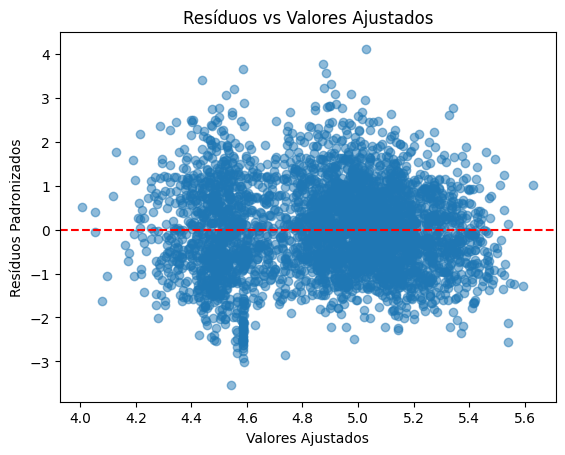

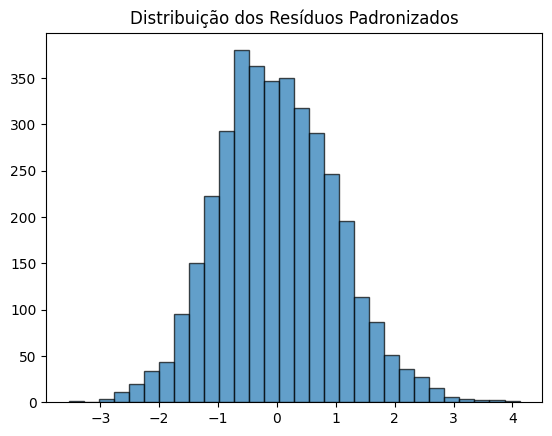

In [32]:
import matplotlib.pyplot as plt

# Resíduos padronizados
standardized_residuals = residuals / residuals.std()

# Gráfico resíduos vs ajustados
plt.scatter(fitted, standardized_residuals, alpha=0.5)
plt.axhline(y=0, color="red", linestyle="--")
plt.xlabel("Valores Ajustados")
plt.ylabel("Resíduos Padronizados")
plt.title("Resíduos vs Valores Ajustados")
plt.show()

# Histograma dos resíduos
plt.hist(standardized_residuals, bins=30, edgecolor="black", alpha=0.7)
plt.title("Distribuição dos Resíduos Padronizados")
plt.show()


In [ ]:
import statsmodels.formula.api as smf

# Modelo Poisson
poisson_model = smf.poisson("IEngajamento ~ posts_per_day + num_hashtags + flesch_index + call_to_action + gov_commented + C(classify_5_inverted) + C(content_type) + C(period_of_day)", data=df).fit()
print(poisson_model.summary())

# Modelo Binomial Negativo
from statsmodels.discrete.discrete_model import NegativeBinomial
nb_model = smf.glm("IEngajamento ~ posts_per_day + num_hashtags + flesch_index + call_to_action + gov_commented + C(classify_5_inverted) + C(content_type) + C(period_of_day)", 
                   data=df, family=sm.families.NegativeBinomial()).fit()
print(nb_model.summary())


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler

# X = todas as variáveis independentes (com dummies já criadas)
# y = variável dependente log-transformada
X = df[variaveis_independentes].copy()
y = df["log_IEngajamento"]

X = pd.get_dummies(X, drop_first=True)
X = sm.add_constant(X).astype(float)

# Padronização (essencial para LASSO/Ridge)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ======= RIDGE =======
ridge = RidgeCV(alphas=np.logspace(-6, 6, 13), cv=10).fit(X_scaled, y)
print("Ridge alpha:", ridge.alpha_)
print("Coeficientes Ridge:", dict(zip(X.columns, ridge.coef_)))

# ======= LASSO =======
lasso = LassoCV(alphas=np.logspace(-6, 1, 200), cv=10).fit(X_scaled, y)
print("Lasso alpha:", lasso.alpha_)
print("Coeficientes LASSO:", dict(zip(X.columns, lasso.coef_)))


ValueError: could not convert string to float: 'Nível 2 (Baixo Detalhe Intermediário)'